In [1]:
import matplotlib.pyplot as plt
import rebound
import numpy as np
%matplotlib inline
plt.style.use('paper')

# F dot dl doesn't (?) work in the rotating frame, because it looks like we just move through a length $\sim \Delta a$, where in reality in the non-rotating frame we're moving over a distance $\sim \Delta a/ e_c \sim a$. Works perfectly in non-rotating frame

symmetric $\Delta t$ around conjunction works well to within 1%

In [2]:
mu=1e-10
j, k = 10, 1
n = 2*np.pi
n20 = n*(j-k)/j
deltan = 0
n2_init = n20 + deltan
deltan0 = n-n20
ec = 2*k/3/j
etilde = 3/10
e = etilde*ec
deltat = 2/3/n20 # time to move delta a in y at a rate delta v
Ndeltat = 4
pomega = 0.
phi = 0.5

In [3]:
def setup(t0=-deltat, theta=None): # make sim with sim.t = t0 (where conjunction always happens near t=0, use get_conjunction_time to get exact)
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1)
    sim.add(m=mu, P=1, 
            l=pomega+phi+n*t0) # phi = l - pomega, so l = pomega+phi
    ps = sim.particles
    if theta is None:
        theta = pomega+phi+n20*t0
    sim.add(P=2*np.pi/(n20+deltan), e=etilde*ec, pomega=pomega, l=theta)
    sim.t = t0
    
    print('Hill radius separation:', (sim.particles[2].a-sim.particles[1].a)/(mu/3)**(1/3))
    return sim

In [4]:
sim = setup(t0=-Ndeltat*deltat+0.05) # Found encounter happened at t=0.05, so shift over so it happens at 0
ps = sim.particles
Nout = 10000
times = np.linspace(-Ndeltat*deltat,Ndeltat*deltat, Nout)
sim.t = times[0]
x, y = np.zeros(Nout), np.zeros(Nout)
vx, vy = np.zeros(Nout), np.zeros(Nout)
n2 = np.zeros(Nout)
Edot = np.zeros(Nout)
for i, t in enumerate(times):
    sim.integrate(t)
    R = np.array([[np.cos(n*t), np.sin(n*t)], [-np.sin(n*t), np.cos(n*t)]])
    x[i], y[i] = np.matmul(R, np.array([ps[2].x, ps[2].y]))-[1, 0] # subtract (1,0) for (x,y) of planet 1 in rotated frame
    Fx = - sim.G*mu*x[i]/(x[i]**2 + y[i]**2)**(3/2)
    Fy = - sim.G*mu*y[i]/(x[i]**2 + y[i]**2)**(3/2)
    n2[i] = ps[2].n
    dx = ps[2].x - ps[1].x
    dy = ps[2].y - ps[1].y
    Edot[i] = -sim.G*ps[1].m*(dx*ps[2].vx + dy*ps[2].vy)/(dx**2 + dy**2)**(3/2)

Hill radius separation: 226.10082738701047


In [5]:
da = ps[2].a-ps[1].a
Edot.max() - abs(Edot.min()), sim.G*ps[1].m/da**3*2*ps[2].a*e*np.sin(phi)*ps[2].v

(-1.3681658568252533e-06, 1.2545682977141114e-06)

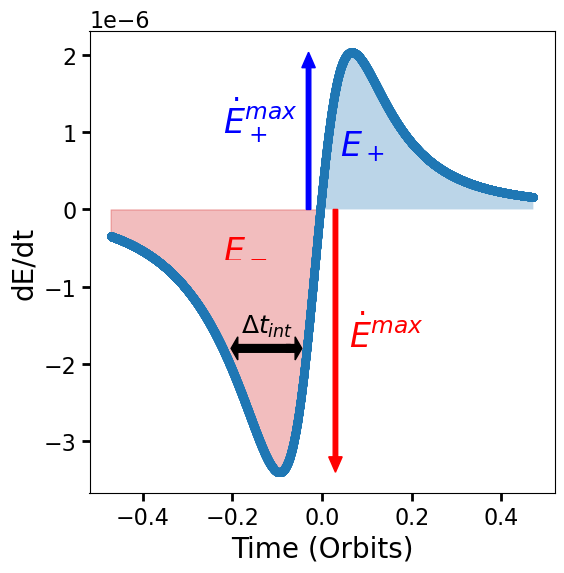

In [10]:
tint = (ps[2].P/3/np.pi)
fig, ax = plt.subplots()
ax.plot(times, Edot, '.')
ax.set_xlabel('Time (Orbits)')
ax.set_ylabel('dE/dt')
ax.text(-0.18, -1.6e-6, '$\Delta t_{int}$', fontsize=18)
ax.fill_between(times[times < 0], 0*times[times < 0], Edot[times < 0], alpha=0.3, color='tab:red')
ax.fill_between(times[times > 0], 0*times[times > 0], Edot[times > 0], alpha=0.3)
ax.text(-0.22, -6e-7, '$E_-$', fontsize=24, color='red')
ax.text(0.04, 7e-7, '$E_+$', fontsize=24, color='blue')
ax.text(0.06, -1.7e-6, '$\dot{E}_-^{max}$', fontsize=24, color='red')
ax.text(-0.22, 1.e-6, '$\dot{E}_+^{max}$', fontsize=24, color='blue')
ax.arrow(x=-0.07, y=-1.8e-6, dx=-tint, dy=0, width=1.e-7, head_length=0.015, facecolor='black', edgecolor='k') 
ax.arrow(x=-0.08, y=-1.8e-6, dx=0.02, dy=0, width=1.e-7, head_length=0.015, facecolor='black', edgecolor='k') 
ax.arrow(x=-0.03, y=0, dx=0, dy=Edot.max()-2e-7, width=0.01, head_length=2e-7, facecolor='blue', edgecolor='blue', zorder=5) 
ax.arrow(x=0.03, y=0, dx=0, dy=Edot.min()+2e-7, width=0.01, head_length=2e-7, facecolor='red', edgecolor='red', zorder=5) 

fig.savefig('kick.pdf', bbox_inches='tight')
#ax2 = ax.twiny()
#ax2.plot(deltan0*times/ec, integrand, '.')
